In [227]:
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import recall_score

from box import Box

import warnings

warnings.filterwarnings(action='ignore')
torch.set_printoptions(sci_mode=True)

In [228]:
config = {
    'data_path' : "/opt/ml/input/data/train" , # 데이터 경로

    'p_dims': [200, 400, 600],
    'dropout_rate' : 0.3,
    'weight_decay' : 0.01,
    'valid_samples' : 10,
    'seed' : 42,
    'anneal_cap' : 0.2,
    'total_anneal_steps' : 200000,

    'lr' : 0.005,
    'batch_size' : 2**13,
    'num_epochs' : 50,
    'num_workers' : 4,
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Box(config)

In [229]:
class MakeMatrixDataSet():
    """
    MatrixDataSet 생성
    """
    def __init__(self, config):
        self.config = config
        self.df = pd.read_csv(os.path.join(self.config.data_path, 'train_ratings.csv'))
        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('item')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('user')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['item'].apply(lambda x : self.item_encoder[x])
        self.df['user_idx'] = self.df['user'].apply(lambda x : self.user_encoder[x])

        self.user_train, self.user_valid = self.generate_sequence_data()

    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder 생성

        Args:
            col (str): 생성할 columns 명
        Returns:
            dict: 생성된 user encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder
    
    def generate_sequence_data(self) -> dict:
        """
        sequence_data 생성

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        for user, item, time in zip(self.df['user_idx'], self.df['item_idx'], self.df['time']):
            users[user].append(item)
        
        for user in users:
            np.random.seed(self.config.seed)

            user_total = users[user]
            valid = np.random.choice(user_total, size = self.config.valid_samples, replace = False).tolist()
            train = list(set(user_total) - set(valid))

            user_train[user] = train
            user_valid[user] = valid # valid_samples 개수 만큼 검증에 활용 (현재 Task와 가장 유사하게)

        return user_train, user_valid
    
    def get_train_valid_data(self):
        return self.user_train, self.user_valid

    def make_matrix(self, user_list, train = True):
        """
        user_item_dict를 바탕으로 행렬 생성
        """
        mat = torch.zeros(size = (user_list.size(0), self.num_item))
        for idx, user in enumerate(user_list):
            if train:
                mat[idx, self.user_train[user.item()]] = 1
            else:
                mat[idx, self.user_train[user.item()] + self.user_valid[user.item()]] = 1
        return mat

In [230]:
class AEDataSet(Dataset):
    def __init__(self, num_user):
        self.num_user = num_user
        self.users = [i for i in range(num_user)]

    def __len__(self):
        return self.num_user

    def __getitem__(self, idx): 
        user = self.users[idx]
        return torch.LongTensor([user])

In [231]:
class MultiVAE(nn.Module):

    def __init__(self, p_dims, dropout_rate = 0.5):
        super(MultiVAE, self).__init__()
        self.p_dims = p_dims
        self.q_dims = p_dims[::-1]

        temp_q_dims = self.q_dims[:-1] + [self.q_dims[-1] * 2]

        self.q_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(temp_q_dims[:-1], temp_q_dims[1:])])

        self.p_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.p_dims[:-1], self.p_dims[1:])])

        self.drop = nn.Dropout(dropout_rate)
        self.init_weights()
    
    def forward(self, input, loss = False):
        mu, logvar = self.encode(input)
        z = self.reparameterize(mu, logvar)
        h = self.decode(z)
        if loss:
            return h, mu, logvar
        else:
            return h
    
    def encode(self, input):
        h = F.normalize(input)
        h = self.drop(h)

        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                h = F.tanh(h)
            else:
                mu = h[:, :self.q_dims[-1]]
                logvar = h[:, self.q_dims[-1]:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        h = z
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = F.tanh(h)
        return h

    def init_weights(self):
        for layer in self.q_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)
        
        for layer in self.p_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)

In [232]:
class MultiDAE(nn.Module):
    
    def __init__(self, p_dims, dropout_rate = 0.5):
        super(MultiDAE, self).__init__()
        self.p_dims = p_dims
        self.q_dims = p_dims[::-1]

        self.dims = self.q_dims + self.p_dims[1:]
        self.layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.dims[:-1], self.dims[1:])])
        self.drop = nn.Dropout(dropout_rate)
        
        self.init_weights()
    
    def forward(self, input):
        h = F.normalize(input)
        h = self.drop(h)

        for i, layer in enumerate(self.layers):
            h = layer(h)
            if i != len(self.layers) - 1:
                h = F.tanh(h)
        return h

    def init_weights(self):
        for layer in self.layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)

In [233]:
class LossFunc(nn.Module):

    def __init__(self, loss_type = 'Multinomial', model_type = None):
        super(LossFunc, self).__init__()
        self.loss_type = loss_type
        self.model_type = model_type

    def forward(self, recon_x = None, x = None, mu = None, logvar = None, anneal = None):
        if self.loss_type == 'Gaussian':
            loss = self.Gaussian(recon_x, x)
        elif self.loss_type == 'Logistic':
            loss = self.Logistic(recon_x, x)
        elif self.loss_type == 'Multinomial':
            loss = self.Multinomial(recon_x, x)
        
        if self.model_type == 'VAE':
            KLD = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
            loss = loss + anneal * KLD
        
        return loss

    def Gaussian(self, recon_x, x):
        gaussian = F.mse_loss(recon_x, x)
        return gaussian

    def Logistic(self, recon_x, x):
        logistic = F.binary_cross_entropy(recon_x.sigmoid(), x, reduction='none').sum(1).mean()
        return logistic

    def Multinomial(self, recon_x, x):
        multinomial = -torch.mean(torch.sum(F.log_softmax(recon_x, 1) * x, -1))
        return multinomial

In [234]:
def get_ndcg(pred_list, true_list):
    idcg = sum((1 / np.log2(rank + 2) for rank in range(1, len(pred_list))))
    dcg = 0
    for rank, pred in enumerate(pred_list):
        if pred in true_list:
            dcg += 1 / np.log2(rank + 2)
    ndcg = dcg / idcg
    return ndcg

def get_hit(pred_list, true_list):
    hit_list = set(true_list) & set(pred_list)
    hit = len(hit_list) / len(true_list)
    return hit

def get_recall(pred_list, true_list, topk=10):
    pred = pred_list[:topk]
    num_hit = len(set(pred).intersection(set(true_list)))
    recall = float(num_hit) / len(true_list)
    return recall

def train(model, criterion, optimizer, data_loader, make_matrix_data_set, config):
    global update_count
    model.train()
    loss_val = 0
    for users in data_loader:
        mat = make_matrix_data_set.make_matrix(users)
        mat = mat.to(device)

        if criterion.model_type == 'VAE':
            anneal = min(config.anneal_cap, 1. * update_count / config.total_anneal_steps)
            update_count += 1
            recon_mat, mu, logvar = model(mat, loss = True)
            
            optimizer.zero_grad()
            loss = criterion(recon_x = recon_mat, x = mat, mu = mu, logvar = logvar, anneal = anneal)

        else:
            recon_mat = model(mat)
            optimizer.zero_grad()
            loss = criterion(recon_x = recon_mat, x = mat)

        loss_val += loss.item()

        loss.backward()
        optimizer.step()

    loss_val /= len(data_loader)

    return loss_val

def evaluate(model, data_loader, user_train, user_valid, make_matrix_data_set):
    model.eval()

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10
    RECALL = 0.0 # RECALL@10
    with torch.no_grad():
        for users in data_loader:
            mat = make_matrix_data_set.make_matrix(users)
            mat = mat.to(device)

            recon_mat = model(mat)
            recon_mat[mat == 1] = -np.inf
            rec_list = recon_mat.argsort(dim = 1)

            for user, rec in zip(users, rec_list):
                uv = user_valid[user.item()]
                up = rec[-10:].cpu().numpy().tolist()
                NDCG += get_ndcg(pred_list = up, true_list = uv)
                HIT += get_hit(pred_list = up, true_list = uv)
                RECALL += get_recall(pred_list = up, true_list = uv)

    NDCG /= len(data_loader.dataset)
    HIT /= len(data_loader.dataset)
    RECALL /= len(data_loader.dataset)

    return NDCG, HIT, RECALL

In [235]:
make_matrix_data_set = MakeMatrixDataSet(config = config)
user_train, user_valid = make_matrix_data_set.get_train_valid_data()

In [236]:
ae_dataset = AEDataSet(
    num_user = make_matrix_data_set.num_user,
    )

In [237]:
data_loader = DataLoader(
    ae_dataset,
    batch_size = config.batch_size, 
    shuffle = True, 
    pin_memory = True,
    num_workers = config.num_workers,
    )

In [238]:
loss_dict = {}
ndcg_dict = {}
hit_dict = {}
recall_dict = {}

In [239]:
model = MultiVAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Multinomial', model_type = 'VAE')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [240]:
best_hit = 0
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
recall_list = []
for epoch in range(1, config.num_epochs + 1):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit, recall = evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)
    recall_list.append(recall)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}| RECALL@10: {recall:.5f}')

Epoch:   1| Train loss: 1312.90219| NDCG@10: 0.07973| HIT@10: 0.06908| RECALL@10: 0.06908
Epoch:   2| Train loss: 1228.21194| NDCG@10: 0.07946| HIT@10: 0.06651| RECALL@10: 0.06651
Epoch:   3| Train loss: 1208.37219| NDCG@10: 0.07211| HIT@10: 0.05942| RECALL@10: 0.05942
Epoch:   4| Train loss: 1204.59354| NDCG@10: 0.08321| HIT@10: 0.07228| RECALL@10: 0.07228
Epoch:   5| Train loss: 1200.26578| NDCG@10: 0.07951| HIT@10: 0.06564| RECALL@10: 0.06564
Epoch:   6| Train loss: 1200.45227| NDCG@10: 0.09508| HIT@10: 0.07988| RECALL@10: 0.07988
Epoch:   7| Train loss: 1198.97620| NDCG@10: 0.08397| HIT@10: 0.07025| RECALL@10: 0.07025
Epoch:   8| Train loss: 1199.31680| NDCG@10: 0.10213| HIT@10: 0.08594| RECALL@10: 0.08594
Epoch:   9| Train loss: 1199.37744| NDCG@10: 0.09987| HIT@10: 0.08458| RECALL@10: 0.08458
Epoch:  10| Train loss: 1197.93668| NDCG@10: 0.10005| HIT@10: 0.08542| RECALL@10: 0.08542
Epoch:  11| Train loss: 1198.02280| NDCG@10: 0.10381| HIT@10: 0.08875| RECALL@10: 0.08875
Epoch:  12

In [241]:
loss_dict['Multi-VAE'] = loss_list
ndcg_dict['Multi-VAE'] = ndcg_list
hit_dict['Multi-VAE'] = hit_list
recall_dict['Multi-VAE'] = recall_list

In [242]:
model = MultiVAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Gaussian', model_type = 'VAE')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [243]:
best_hit = 0
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
recall_list = []
for epoch in range(1, config.num_epochs + 1):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit, recall = evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)
    recall_list.append(recall)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}| RECALL@10: {recall:.5f}')

Epoch:   1| Train loss: 0.03531| NDCG@10: 0.08816| HIT@10: 0.07505| RECALL@10: 0.07505
Epoch:   2| Train loss: 0.04148| NDCG@10: 0.00199| HIT@10: 0.00165| RECALL@10: 0.00165
Epoch:   3| Train loss: 0.06845| NDCG@10: 0.00183| HIT@10: 0.00138| RECALL@10: 0.00138
Epoch:   4| Train loss: 0.04239| NDCG@10: 0.00049| HIT@10: 0.00039| RECALL@10: 0.00039
Epoch:   5| Train loss: 0.04189| NDCG@10: 0.00320| HIT@10: 0.00249| RECALL@10: 0.00249
Epoch:   6| Train loss: 0.03021| NDCG@10: 0.10430| HIT@10: 0.08861| RECALL@10: 0.08861
Epoch:   7| Train loss: 0.02630| NDCG@10: 0.10637| HIT@10: 0.09223| RECALL@10: 0.09223
Epoch:   8| Train loss: 0.02425| NDCG@10: 0.10697| HIT@10: 0.09280| RECALL@10: 0.09280
Epoch:   9| Train loss: 0.02262| NDCG@10: 0.10666| HIT@10: 0.09243| RECALL@10: 0.09243
Epoch:  10| Train loss: 0.02177| NDCG@10: 0.10727| HIT@10: 0.09288| RECALL@10: 0.09288
Epoch:  11| Train loss: 0.02114| NDCG@10: 0.10759| HIT@10: 0.09326| RECALL@10: 0.09326
Epoch:  12| Train loss: 0.02069| NDCG@10: 0

In [244]:
loss_dict['Gaussian-VAE'] = loss_list
ndcg_dict['Gaussian-VAE'] = ndcg_list
hit_dict['Gaussian-VAE'] = hit_list
recall_dict['Gaussian-VAE'] = recall_list

In [245]:
model = MultiVAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Logistic', model_type = 'VAE')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [246]:
best_hit = 0
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
recall_list = []
for epoch in range(1, config.num_epochs + 1):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit, recall = evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)
    recall_list.append(recall)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}| RECALL@10: {recall:.5f}')

Epoch:   1| Train loss: 2961.36230| NDCG@10: 0.07020| HIT@10: 0.06075| RECALL@10: 0.06075
Epoch:   2| Train loss: 630.36646| NDCG@10: 0.10120| HIT@10: 0.08635| RECALL@10: 0.08635
Epoch:   3| Train loss: 617.04128| NDCG@10: 0.07833| HIT@10: 0.06423| RECALL@10: 0.06423
Epoch:   4| Train loss: 601.09113| NDCG@10: 0.09302| HIT@10: 0.08034| RECALL@10: 0.08034
Epoch:   5| Train loss: 588.83255| NDCG@10: 0.09574| HIT@10: 0.08456| RECALL@10: 0.08456
Epoch:   6| Train loss: 579.18048| NDCG@10: 0.09894| HIT@10: 0.08536| RECALL@10: 0.08536
Epoch:   7| Train loss: 572.83667| NDCG@10: 0.10125| HIT@10: 0.08785| RECALL@10: 0.08785
Epoch:   8| Train loss: 568.68671| NDCG@10: 0.10268| HIT@10: 0.08895| RECALL@10: 0.08895
Epoch:   9| Train loss: 566.93684| NDCG@10: 0.10023| HIT@10: 0.08782| RECALL@10: 0.08782
Epoch:  10| Train loss: 564.64314| NDCG@10: 0.10091| HIT@10: 0.08859| RECALL@10: 0.08859
Epoch:  11| Train loss: 564.68492| NDCG@10: 0.10287| HIT@10: 0.08995| RECALL@10: 0.08995
Epoch:  12| Train lo

In [247]:
loss_dict['Logistic-VAE'] = loss_list
ndcg_dict['Logistic-VAE'] = ndcg_list
hit_dict['Logistic-VAE'] = hit_list
recall_dict['Logistic-VAE'] = recall_list

In [248]:
model = MultiDAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Multinomial')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay = config.weight_decay)

In [249]:
best_hit = 0
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
recall_list = []
for epoch in range(1, config.num_epochs + 1):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit, recall = evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)
    recall_list.append(recall)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}| RECALL@10: {recall:.5f}')

Epoch:   1| Train loss: 1288.55084| NDCG@10: 0.09282| HIT@10: 0.07828| RECALL@10: 0.07828
Epoch:   2| Train loss: 1435.84229| NDCG@10: 0.09708| HIT@10: 0.08311| RECALL@10: 0.08311
Epoch:   3| Train loss: 1244.60217| NDCG@10: 0.07675| HIT@10: 0.06578| RECALL@10: 0.06578
Epoch:   4| Train loss: 1227.99194| NDCG@10: 0.05719| HIT@10: 0.04676| RECALL@10: 0.04676
Epoch:   5| Train loss: 1208.81906| NDCG@10: 0.09077| HIT@10: 0.07864| RECALL@10: 0.07864
Epoch:   6| Train loss: 1200.79504| NDCG@10: 0.07949| HIT@10: 0.06625| RECALL@10: 0.06625
Epoch:   7| Train loss: 1191.19220| NDCG@10: 0.09878| HIT@10: 0.08354| RECALL@10: 0.08354
Epoch:   8| Train loss: 1183.95941| NDCG@10: 0.08722| HIT@10: 0.07435| RECALL@10: 0.07435
Epoch:   9| Train loss: 1179.60544| NDCG@10: 0.10421| HIT@10: 0.08659| RECALL@10: 0.08659
Epoch:  10| Train loss: 1190.39899| NDCG@10: 0.09273| HIT@10: 0.07803| RECALL@10: 0.07803
Epoch:  11| Train loss: 1182.84787| NDCG@10: 0.10234| HIT@10: 0.08617| RECALL@10: 0.08617
Epoch:  12

In [250]:
loss_dict['Multi-DAE'] = loss_list
ndcg_dict['Multi-DAE'] = ndcg_list
hit_dict['Multi-DAE'] = hit_list
recall_dict['Multi-DAE'] = recall_list


In [251]:
model = MultiDAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Gaussian')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay = config.weight_decay)

In [252]:
best_hit = 0
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
recall_list = []
for epoch in range(1, config.num_epochs + 1):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit, recall = evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)
    recall_list.append(recall)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}| RECALL@10: {recall:.5f}')

Epoch:   1| Train loss: 0.02251| NDCG@10: 0.10479| HIT@10: 0.08940| RECALL@10: 0.08940
Epoch:   2| Train loss: 0.02250| NDCG@10: 0.10337| HIT@10: 0.08975| RECALL@10: 0.08975
Epoch:   3| Train loss: 0.02251| NDCG@10: 0.09039| HIT@10: 0.08136| RECALL@10: 0.08136
Epoch:   4| Train loss: 0.02256| NDCG@10: 0.07654| HIT@10: 0.06428| RECALL@10: 0.06428
Epoch:   5| Train loss: 0.02252| NDCG@10: 0.10600| HIT@10: 0.08526| RECALL@10: 0.08526
Epoch:   6| Train loss: 0.02250| NDCG@10: 0.10365| HIT@10: 0.09020| RECALL@10: 0.09020
Epoch:   7| Train loss: 0.02249| NDCG@10: 0.10174| HIT@10: 0.08892| RECALL@10: 0.08892
Epoch:   8| Train loss: 0.02250| NDCG@10: 0.10125| HIT@10: 0.08803| RECALL@10: 0.08803
Epoch:   9| Train loss: 0.02250| NDCG@10: 0.10534| HIT@10: 0.09067| RECALL@10: 0.09067
Epoch:  10| Train loss: 0.02249| NDCG@10: 0.10408| HIT@10: 0.09045| RECALL@10: 0.09045
Epoch:  11| Train loss: 0.02250| NDCG@10: 0.10431| HIT@10: 0.09057| RECALL@10: 0.09057
Epoch:  12| Train loss: 0.02250| NDCG@10: 0

In [253]:
loss_dict['Gaussian-DAE'] = loss_list
ndcg_dict['Gaussian-DAE'] = ndcg_list
hit_dict['Gaussian-DAE'] = hit_list
recall_dict['Gaussian-DAE'] = recall_list

In [254]:
model = MultiDAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Logistic')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay = config.weight_decay)

In [255]:
best_hit = 0
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
recall_list = []
for epoch in range(1, config.num_epochs + 1):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit, recall = evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)
    recall_list.append(recall)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}| RECALL@10: {recall:.5f}')

Epoch:   1| Train loss: 2994.06479| NDCG@10: 0.06324| HIT@10: 0.05108| RECALL@10: 0.05108
Epoch:   2| Train loss: 605.46179| NDCG@10: 0.09792| HIT@10: 0.08482| RECALL@10: 0.08482
Epoch:   3| Train loss: 607.64772| NDCG@10: 0.09317| HIT@10: 0.07879| RECALL@10: 0.07879
Epoch:   4| Train loss: 598.05183| NDCG@10: 0.09640| HIT@10: 0.07926| RECALL@10: 0.07926
Epoch:   5| Train loss: 588.75107| NDCG@10: 0.09562| HIT@10: 0.08317| RECALL@10: 0.08317
Epoch:   6| Train loss: 579.33124| NDCG@10: 0.10047| HIT@10: 0.08296| RECALL@10: 0.08296
Epoch:   7| Train loss: 573.47148| NDCG@10: 0.09803| HIT@10: 0.08522| RECALL@10: 0.08522
Epoch:   8| Train loss: 568.62627| NDCG@10: 0.10112| HIT@10: 0.08685| RECALL@10: 0.08685
Epoch:   9| Train loss: 566.19476| NDCG@10: 0.10080| HIT@10: 0.08717| RECALL@10: 0.08717
Epoch:  10| Train loss: 564.27657| NDCG@10: 0.10266| HIT@10: 0.08892| RECALL@10: 0.08892
Epoch:  11| Train loss: 563.64217| NDCG@10: 0.10172| HIT@10: 0.08855| RECALL@10: 0.08855
Epoch:  12| Train lo

In [256]:
loss_dict['Logistic-DAE'] = loss_list
ndcg_dict['Logistic-DAE'] = ndcg_list
hit_dict['Logistic-DAE'] = hit_list
recall_dict['Logistic-DAE'] = recall_list

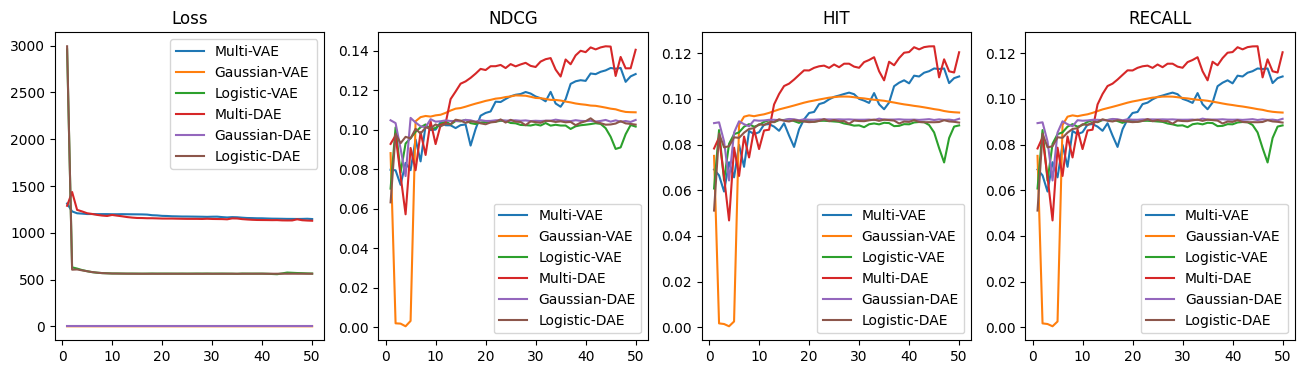

In [257]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize = (16, 4))
ax = ax.flatten()
epochs = [i for i in range(1, config.num_epochs + 1)]

for k in loss_dict.keys():
    ax[0].plot(epochs, loss_dict[k], label = k)
ax[0].set_title('Loss')
ax[0].legend()

for k in ndcg_dict.keys():
    ax[1].plot(epochs, ndcg_dict[k], label = k)
ax[1].set_title('NDCG')
ax[1].legend()

for k in hit_dict.keys():
    ax[2].plot(epochs, hit_dict[k], label = k)
ax[2].set_title('HIT')
ax[2].legend()

for k in recall_dict.keys():
    ax[3].plot(epochs, recall_dict[k], label = k)
ax[3].set_title('RECALL')
ax[3].legend()

plt.show()